In [23]:
!pip install astroquery matplotlib numpy
!pip install astropy

In [24]:
from astroquery.sdss import SDSS
from astropy.table import Table
from scipy.interpolate import interp1d
import pandas as pd
import numpy as np

object_types = ['STAR', 'GALAXY', 'QSO']
spectra_data = []

for obj_type in object_types:
    print(f"\n Fetching spectra for: {obj_type}")

    # SQL query for 10 good spectra of the given class
    query = f"SELECT TOP 10 plate, fiberID, mjd FROM SpecObj WHERE class = '{obj_type}' AND zWarning = 0"


    results = SDSS.query_sql(query, data_release=16)

    if results is None:
        print(f" No results found for {obj_type}")
        continue

    for row in results:
        plate = int(row['plate'])
        fiberID = int(row['fiberID'])
        mjd = int(row['mjd'])

        try:
            spectrum = SDSS.get_spectra(plate=plate, fiberID=fiberID, mjd=mjd)

            if spectrum is not None and len(spectrum) > 0:
                data = spectrum[0][1].data
                wavelength = 10 ** data['loglam']
                flux = data['flux']

                spectra_data.append({
                    'wavelength': wavelength,
                    'flux': flux,
                    'label': obj_type
                })
        except Exception as e:
            print(f" Error fetching spectrum: {e}")

print(f"\n Fetched {len(spectra_data)} spectra in total.")



 Fetching spectra for: STAR

 Fetching spectra for: GALAXY

 Fetching spectra for: QSO

 Fetched 30 spectra in total.


In [25]:
from scipy.interpolate import interp1d
import pandas as pd
import numpy as np

common_wavelength = np.linspace(4000, 9000, 1000)
X = []
y = []

for entry in spectra_data:
    wl = entry['wavelength']
    flux = entry['flux']
    label = entry['label']

    print(f" Processing {label} — {len(wl)} wavelength points")

    if len(wl) < 10 or len(flux) < 10:
        print(f" Skipping {label} — too few data points")
        continue

    try:
        interp_func = interp1d(wl, flux, kind='linear', bounds_error=False, fill_value=0.0)
        flux_interp = interp_func(common_wavelength)
        X.append(flux_interp)
        y.append(label)
        print(f" Interpolated {label} — added to dataset")
    except Exception as e:
        print(f" Error interpolating {label}: {e}")

# Build DataFrame
df = pd.DataFrame(X)
df['label'] = y

from collections import Counter
print("\n Final Label Counts:", Counter(df['label']))
print(" DataFrame shape:", df.shape)


 Processing STAR — 3844 wavelength points
 Interpolated STAR — added to dataset
 Processing STAR — 3844 wavelength points
 Interpolated STAR — added to dataset
 Processing STAR — 3845 wavelength points
 Interpolated STAR — added to dataset
 Processing STAR — 3845 wavelength points
 Interpolated STAR — added to dataset
 Processing STAR — 3816 wavelength points
 Interpolated STAR — added to dataset
 Processing STAR — 3844 wavelength points
 Interpolated STAR — added to dataset
 Processing STAR — 3842 wavelength points
 Interpolated STAR — added to dataset
 Processing STAR — 3842 wavelength points
 Interpolated STAR — added to dataset
 Processing STAR — 3840 wavelength points
 Interpolated STAR — added to dataset
 Processing STAR — 3840 wavelength points
 Interpolated STAR — added to dataset
 Processing GALAXY — 3845 wavelength points
 Interpolated GALAXY — added to dataset
 Processing GALAXY — 3845 wavelength points
 Interpolated GALAXY — added to dataset
 Processing GALAXY — 3845 wavele

In [26]:
# Save as CSV
df.to_csv("spectral_dataset.csv", index=False)

# Optional: save as parquet (faster, better for large data later)
df.to_parquet("spectral_dataset.parquet", index=False)

print(" Saved 'spectral_dataset.csv' and 'spectral_dataset.parquet'")
from google.colab import files
files.download("spectral_dataset.csv")


 Saved 'spectral_dataset.csv' and 'spectral_dataset.parquet'


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


 Classification Report:
               precision    recall  f1-score   support

      GALAXY       0.60      1.00      0.75         3
         QSO       1.00      0.33      0.50         3
        STAR       1.00      1.00      1.00         3

    accuracy                           0.78         9
   macro avg       0.87      0.78      0.75         9
weighted avg       0.87      0.78      0.75         9



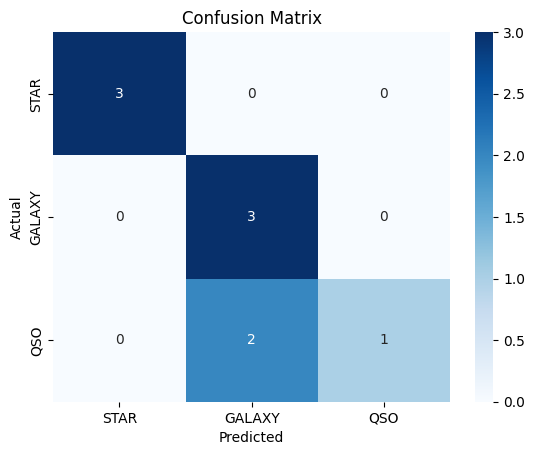

In [27]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Split into features + labels
X = df.drop('label', axis=1)
y = df['label']

# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Train logistic regression model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluation
print("\n Classification Report:\n", classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=['STAR', 'GALAXY', 'QSO'])
sns.heatmap(cm, annot=True, fmt='d', xticklabels=['STAR', 'GALAXY', 'QSO'], yticklabels=['STAR', 'GALAXY', 'QSO'], cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


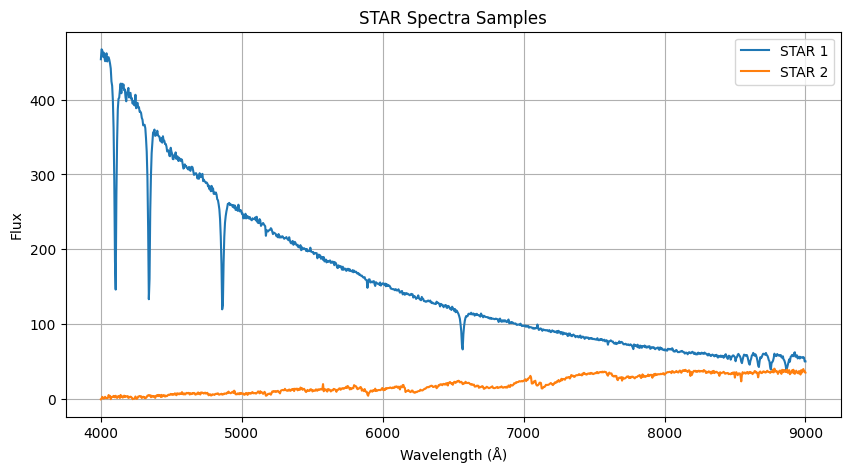

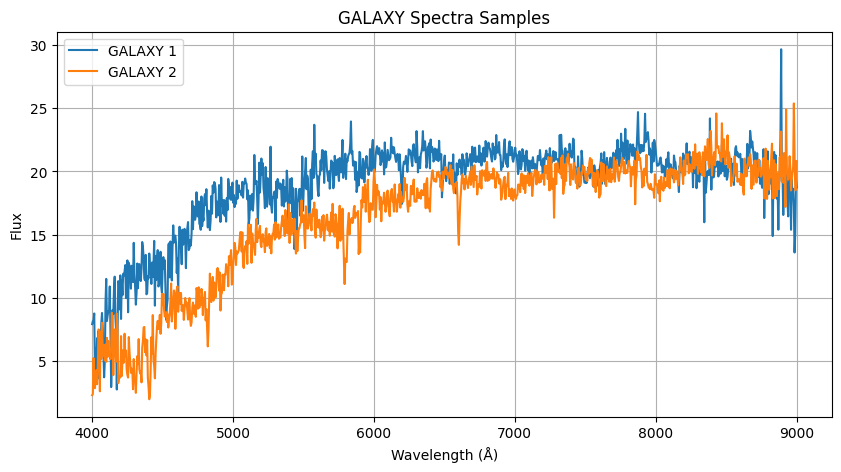

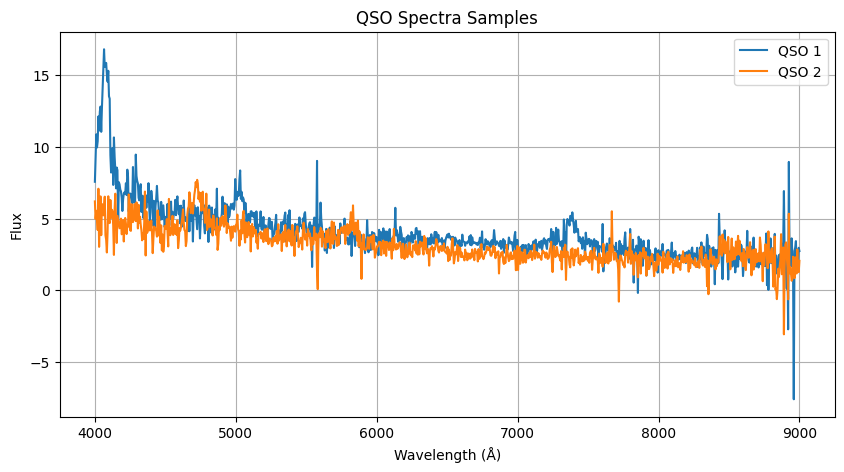

In [28]:
import matplotlib.pyplot as plt

# Plot samples
def plot_class_spectra(spectra_data, common_wavelength, class_name, n_samples=2):
    plt.figure(figsize=(10, 5))
    count = 0
    for entry in spectra_data:
        if entry['label'] == class_name:
            wl = entry['wavelength']
            flux = entry['flux']

            if len(wl) < 10 or len(flux) < 10:
                continue

            interp_func = interp1d(wl, flux, kind='linear', bounds_error=False, fill_value=0.0)
            flux_interp = interp_func(common_wavelength)
            plt.plot(common_wavelength, flux_interp, label=f"{class_name} {count+1}")

            count += 1
            if count >= n_samples:
                break
    plt.title(f"{class_name} Spectra Samples")
    plt.xlabel("Wavelength (Å)")
    plt.ylabel("Flux")
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot 2 spectra from each class
for obj_type in ['STAR', 'GALAXY', 'QSO']:
    plot_class_spectra(spectra_data, common_wavelength, obj_type, n_samples=2)
